In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import scipy

sc.settings.verbosity = 2
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.4 umap==0.5.7 numpy==1.26.4 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


# Load in the data

In [19]:
path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad"

adata_raw = sc.read_h5ad(path)
print(f"Initial shape: {adata_raw.shape}\n")
print(f"N cells in HYB dataset: {adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs}")
print(f"N cells in scFib dataset: {adata_raw[adata_raw.obs['dataset'] == 'Control'].n_obs}\n")

adata_raw

Initial shape: (19858, 28702)

N cells in HYB dataset: 10895
N cells in scFib dataset: 8963



AnnData object with n_obs × n_vars = 19858 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

In [20]:
### --- Handle HYB cells with NaN feature barcode predictions ---
init_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs

# remove HYB cells with NaN feature barcode predictions
hybrid_to_remove = (adata_raw.obs['dataset'] == 'Hybrid') & (adata_raw.obs['assigned_condition'].isna())
cells_to_keep = ~(hybrid_to_remove)
adata_raw = adata_raw[cells_to_keep].copy()

final_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs
removed_hybrid_cells = init_cells_hybrid - final_cells_hybrid

print(f"Removed {removed_hybrid_cells} 'Hybrid' cells with unassigned feature barcodes")
print(f"Final shape: {adata_raw.shape}")


### --- Add new column for grouping HYB cells vs Controls ---
adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({
    "G1": "Control",
    "S": "Control",
    "G2M": "Control",
    "PRRX1": "siPRRX1",
    "PRRX1_MYOD": "siPRRX1/mmMYOD1",
    "MYOD": "mmMYOD1"
})

# fill remaining NaN feature barcode predictions (only control cells) with 'Control'
adata_raw.obs['pooled_condition'] = adata_raw.obs['pooled_condition'].fillna('Control')
print(adata_raw.obs['pooled_condition'].value_counts())

adata_raw

Removed 1 'Hybrid' cells with unassigned feature barcodes
Final shape: (19857, 28702)
pooled_condition
Control            8963
siPRRX1/mmMYOD1    4174
siPRRX1            3955
mmMYOD1            2765
Name: count, dtype: int64


/tmp/ipykernel_2689189/1807916870.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({


AnnData object with n_obs × n_vars = 19857 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

# QC and Filtering

In [21]:
adata = adata_raw.copy()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)


adata.raw = adata  # keep full dimension safe
adata.layers['raw_counts'] = adata.X.copy()

print("Filtering...\n")

adata = adata[adata.obs.pct_counts_mt < 20]
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_counts=10)

print("\nNormalizing counts...\n")
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
    exclude_highly_expressed=True, 
)

adata.layers['norm_counts'] = adata.X.copy()

sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

print(adata)

print(adata.obs['dataset'].value_counts())
adata.obs['pooled_condition'].value_counts()

Filtering...

filtered out 626 cells that have less than 500 counts
filtered out 3359 genes that are detected in less than 10 counts

Normalizing counts...

normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['CCL5', 'CXCL8', 'IFIT2', 'IFNL1', 'LINC02757', 'MALAT1', 'MT-ATP8', 'MT-ND2', 'MT-ND4', 'MT2A', 'TMSB10']
    finished (0:00:00)
AnnData object with n_obs × n_vars = 17873 × 25343
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',

pooled_condition
Control            7505
siPRRX1/mmMYOD1    3883
siPRRX1            3858
mmMYOD1            2627
Name: count, dtype: int64

# HVGs

extracting highly variable genes
    finished (0:00:04)
Number of HVG: 2000


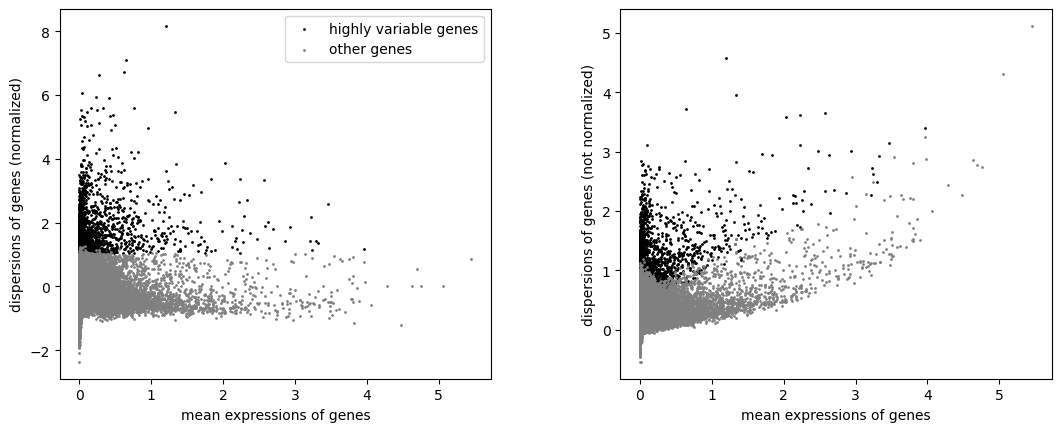

In [22]:
adata.X = adata.layers['log_norm']

sc.pp.highly_variable_genes(
    adata,
    batch_key='dataset',
    n_top_genes=2000, 
)

print(f"Number of HVG: {adata.var['highly_variable'].sum()}")

sc.pl.highly_variable_genes(adata)

# PCA

computing PCA
    with n_comps=50
    finished (0:00:02)


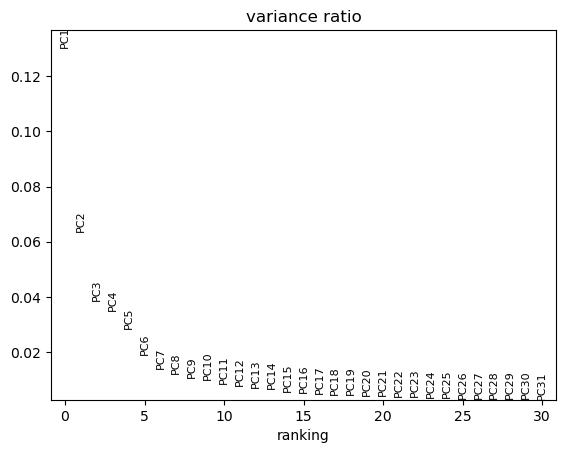

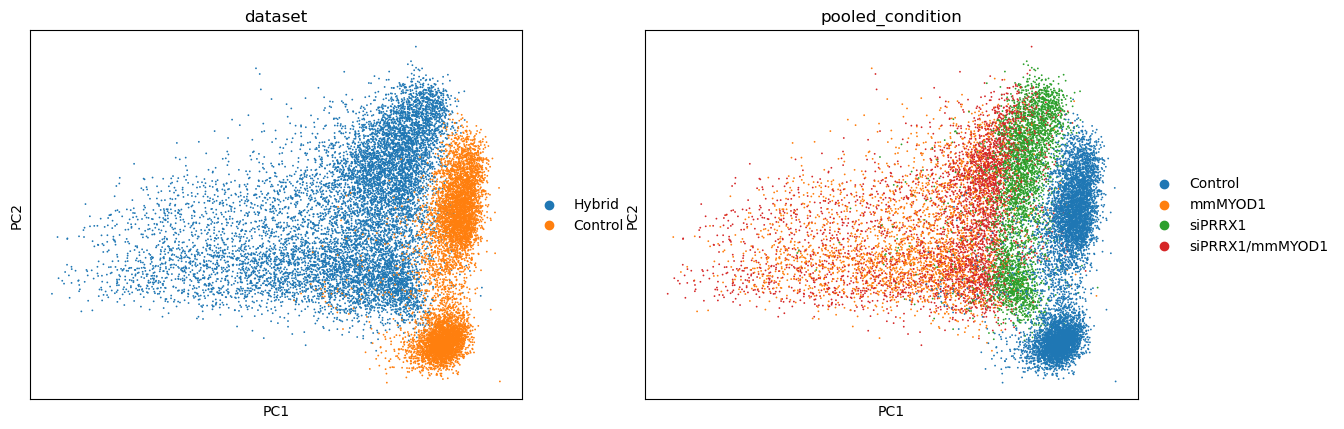

AnnData object with n_obs × n_vars = 17873 × 25343
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 

In [23]:
sc.pp.pca(adata)

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color=['dataset', 'pooled_condition'])

adata

# Harmony integration

2025-05-28 16:18:43,898 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Wed May 28 16:18:43 2025 INFO Computing initial centroids with sklearn.KMeans...
2025-05-28 16:18:47,128 - harmonypy - INFO - sklearn.KMeans initialization complete.
Wed May 28 16:18:47 2025 INFO sklearn.KMeans initialization complete.
2025-05-28 16:18:47,208 - harmonypy - INFO - Iteration 1 of 10
Wed May 28 16:18:47 2025 INFO Iteration 1 of 10
2025-05-28 16:18:51,179 - harmonypy - INFO - Iteration 2 of 10
Wed May 28 16:18:51 2025 INFO Iteration 2 of 10
2025-05-28 16:18:55,092 - harmonypy - INFO - Converged after 2 iterations
Wed May 28 16:18:55 2025 INFO Converged after 2 iterations


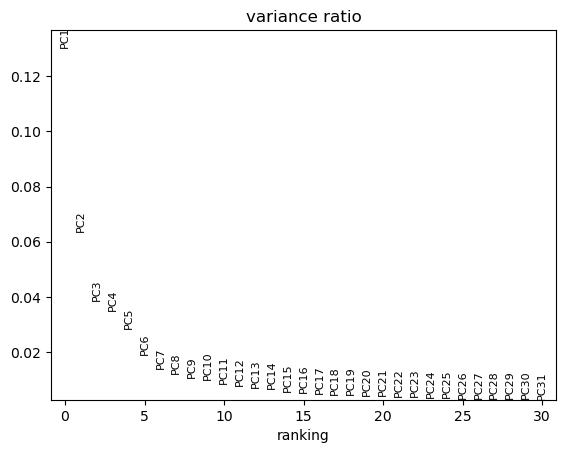

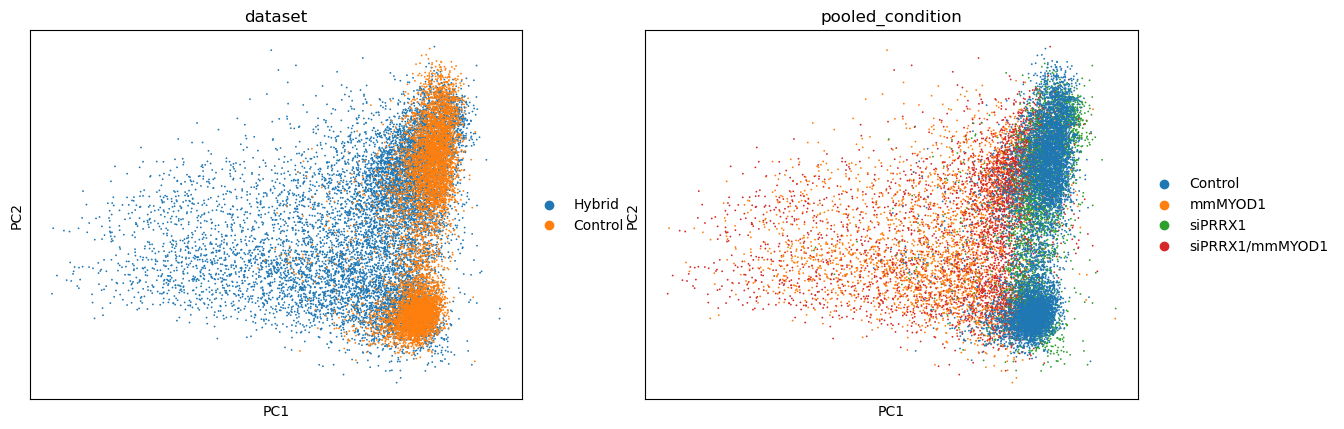

In [24]:
sce.pp.harmony_integrate(adata, 'dataset')

# Save original PCA space
adata.obsm["X_pca_original"] = adata.obsm["X_pca"].copy()

# Set Harmony-corrected PCA as the default for plotting and MAGIC imputation
adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"].copy()

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color=['dataset', 'pooled_condition'])

# UMAP

computing neighbors
    finished (0:00:02)
computing UMAP
    finished (0:00:13)
running Leiden clustering
    finished (0:00:00)


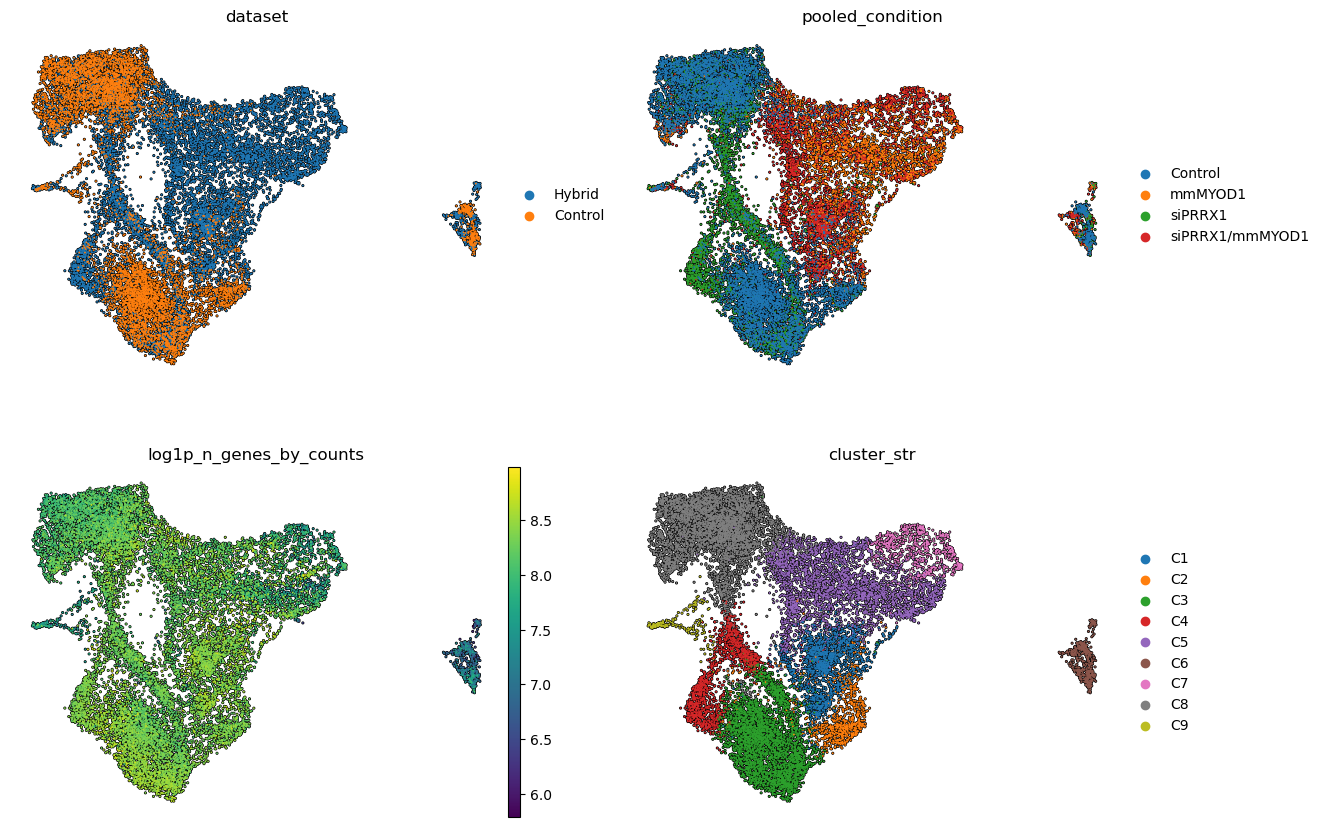

In [25]:
sc.pp.neighbors(
    adata,
    use_rep='X_pca_harmony',
    n_neighbors=10,
)

sc.tl.umap(
    adata,
    min_dist=0.25
)

sc.tl.leiden(
    adata,
    resolution=0.5,
    flavor="igraph",
    n_iterations=-1, 
)

adata.obs['cluster_str'] = adata.obs['leiden'].apply(lambda x: f"C{str(int(x) + 1)}")

sc.pl.umap(
    adata,
    color=['dataset', 'pooled_condition', 'log1p_n_genes_by_counts', 'cluster_str'],
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

# Score cell cycle genes

S phase genes: 43
G2M phase genes: 54
calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01)
computing score 'G2M_score'
    finished (0:00:01)


... storing 'phase' as categorical


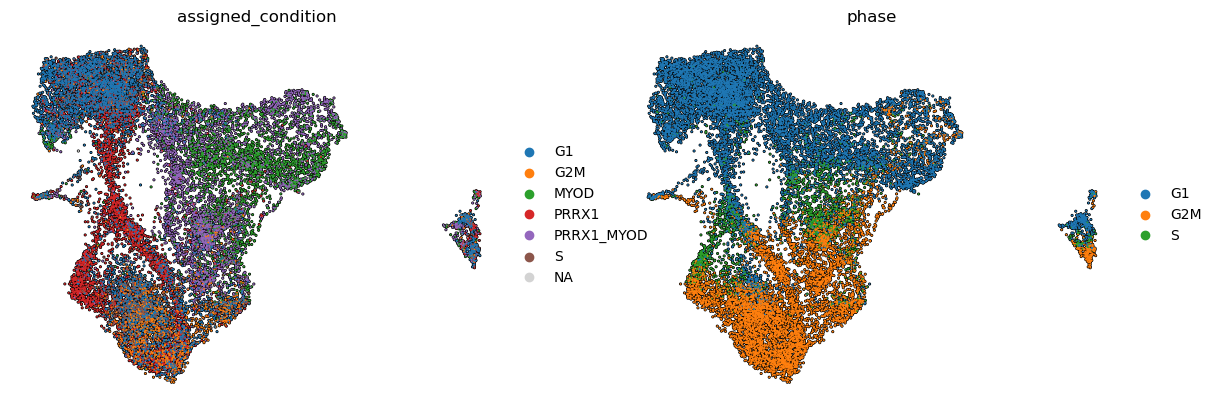

AnnData object with n_obs × n_vars = 17873 × 25343
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'leiden', 'cluster_str', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches'

In [26]:
path = "/nfs/turbo/umms-indikar/Ram/projects/reprogramming/Genexpression/Pseudotime/data/regev_lab_cell_cycle_genes.txt"

cell_cycle_genes = [x.strip() for x in open(path)]

s_genes = cell_cycle_genes[:43]
print(f"S phase genes: {len(s_genes)}")

g2m_genes = cell_cycle_genes[43:]
print(f"G2M phase genes: {len(g2m_genes)}")

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
)

sc.pl.umap(
    adata,
    color=['assigned_condition', 'phase'],
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

adata

In [27]:
### --- Add filtering metadata to adata.uns ---
adata.uns['processing_parameters'] = {
    'max_pct_mito': 20,
    'min_counts_per_cell': 500,
    'min_counts_per_gene': 10,
    'Normalization': 'Raw counts normalized to 10,000 per cell, with highly expressed genes excluded. Normalized counts were then log transformed.',
    'HVGs': 'Default flavor. 2,000 total HVGs selected with batch_key = dataset.',
    'Integration': 'Datasets integrated using Harmony with default parameters.',
    'UMAP': 'Neighbors selected using Harmony-corrected PCA (n=10). min_dist = 0.25.',
    'Cell cycle phases': 'Cell cycle phases were predicted using the Regev Lab genes.',
}

adata.uns['processing_parameters']

{'max_pct_mito': 20,
 'min_counts_per_cell': 500,
 'min_counts_per_gene': 10,
 'Normalization': 'Raw counts normalized to 10,000 per cell, with highly expressed genes excluded. Normalized counts were then log transformed.',
 'HVGs': 'Default flavor. 2,000 total HVGs selected with batch_key = dataset.',
 'Integration': 'Datasets integrated using Harmony with default parameters.',
 'UMAP': 'Neighbors selected using Harmony-corrected PCA (n=10). min_dist = 0.25.',
 'Cell cycle phases': 'Cell cycle phases were predicted using the Regev Lab genes.'}

In [29]:
adata.write_h5ad("/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_merged_gene_data.h5ad")
adata

AnnData object with n_obs × n_vars = 17873 × 25343
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'leiden', 'cluster_str', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches'